# bigram HMM with add-$\alpha$ smoothing

## Bayesian interpretation of add-$\alpha$ smoothing

$ \theta \sim Dirichlet(\alpha + 1), x \sim Categorical(\theta) $

Under MAP estimation given the training data $\mathcal{D} = {x_1, ..., x_N}$

$$ \hat{\theta} = \arg max_{\theta} p(\mathcal{D}|\theta)p(\theta) = \arg max_{\theta} \prod_{i=1}^N p(x_i|\theta)p(\theta) $$

We can have $\hat{\theta_i} =  \frac{count(x=i)+\alpha_i}{N+\sum_j \alpha_j}$

Apply for statistical POS tagging

$\arg max_t Pr(t|w) \propto \arg max_t Pr(t) Pr(w|t)$

1. Learning the transition probabilities:

$P(t_j|t_i)=\frac{C(t_i,t_j)}{C(t_i)}$

2. Learning the emission probabilities:

$P(w_j|t_i)=\frac{C(w_j|t_i)}{C(t_i)}$

So we only need to count $C(t_i,t_j), C(t_i), C(w_j|t_i)$

Considering add-$\alpha$ smoothing, refine as follow

1. Learning the transition probabilities:

$P(t_j|t_i)=\frac{C(t_i,t_j) + \alpha }{C(t_i) + VT \alpha}, VT = |t|$

2. Learning the emission probabilities:

$P(w_j|t_i)=\frac{C(w_j|t_i) + \alpha }{C(t_i) + VW \alpha}, VW = |w|$

In [1]:
import numpy as np
import math
import os
import nltk
import collections
from sklearn import metrics
from tqdm import tqdm
import argparse
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix

In [2]:
def load_treebank_splits(datadir):
    train = []
    dev = []
    test = []
    print("Loading treebank data...")
    for subdir, dirs, files in os.walk(datadir):
        for filename in files:
            if filename.endswith(".pos"):
                filepath = subdir + os.sep + filename
                with open(filepath, "r") as fh:
                    text = fh.read()
                    # train: 20
                    if int(subdir.split(os.sep)[-1]) in range(0, 19):
                        train += get_tagged_sentences(text)
                    # dev: 4
                    if int(subdir.split(os.sep)[-1]) in range(19, 22):
                        dev += get_tagged_sentences(text)
                    # test: 4
                    if int(subdir.split(os.sep)[-1]) in range(22, 25):
                        test += get_tagged_sentences(text)
    print("Train set size: ", len(train))
    print("Dev set size: ", len(dev))
    print("Test set size: ", len(test))
    return train, dev, test

def get_tagged_sentences(text):
    sentences = []

    blocks = text.split("======================================")
    for block in blocks:
        sents = block.split("\n\n")
        for sent in sents:
            sent = sent.replace("\n", "").replace("[", "").replace("]", "")
            if sent != "":
                sentences.append(sent)
    return sentences

def get_token_tag_tuples(sent):
    return([nltk.tag.str2tuple(t) for t in sent.split()])

## When processing the sentence, add <START> <STOP> into the sentence and set START, STOP for their tags

In [19]:
def calculate_transition_probability(c_bigram_tag_dict, c_single_tag_dict, alpha:float=0.):
    bigram_transition_prob_dict = collections.defaultdict(lambda: 0)
    V = len(c_single_tag_dict)
    for (t0, t1), cnt in c_bigram_tag_dict.items():
        # bigram_transition_prob_dict[(t0, t1)] = pr(t1|t0)
        bigram_transition_prob_dict[(t0, t1)] = (cnt+alpha)/(c_single_tag_dict[t0] + V*alpha)
    print(f"Generate bigram_transition_prob_dict for (t_i-1, t_i), pr(t_i-1|t_i) = {len(bigram_transition_prob_dict)}")
    return bigram_transition_prob_dict

def calculate_emission_probability(emission_dict, c_single_tag_dict, V, alpha:float=0.):
    emission_prob_dict = collections.defaultdict(lambda: 0)
    for (w, t), cnt in emission_dict.items():
        # pr(w|t)
        emission_prob_dict[(w, t)] = (cnt+alpha)/(c_single_tag_dict[t] + V*alpha)
    print(f"Generate emission_prob_dict for (w_i, t_i), pr(w_i|t_i) = {len(emission_prob_dict)}")
    return emission_prob_dict

def refine_sentence(s):
    return [('<START>', 'START')] + s + [('<STOP>', 'STOP')]

def train_model(train):
    train_sentences = [get_token_tag_tuples(sent) for sent in train]
    c_bigram_tag_dict = collections.defaultdict(lambda: 0)
    c_single_tag_dict = collections.defaultdict(lambda: 0)
    emission_dict = collections.defaultdict(lambda: 0)
    word_cnt_dict = collections.defaultdict(lambda: 0)

    for i, s in enumerate(train_sentences):
        sentence = refine_sentence(s)
        c_single_tag_dict[sentence[0][1]] += 1; emission_dict[sentence[0]] += 1; 
        word_cnt_dict['<START>'] += 1; word_cnt_dict['<STOP>'] += 1
        for j in range(1, len(sentence)):
            c_bigram_tag_dict[(sentence[j-1][1], sentence[j][1])] += 1
            c_single_tag_dict[sentence[j][1]] += 1
            emission_dict[sentence[j]] += 1
            word_cnt_dict[sentence[j][0]] += 1
    
    print(f"Finish training of HMM |c_bigram_tag_dict|={len(c_bigram_tag_dict)}, |c_single_tag_dict|={len(c_single_tag_dict)}, |emission_dict|={len(emission_dict)}, |word_cnt_dict|={len(word_cnt_dict)}, |tags|={len(list(c_single_tag_dict.keys()))} with START, STOP")
    return c_bigram_tag_dict, c_single_tag_dict, emission_dict, word_cnt_dict, list(c_single_tag_dict.keys())

## Viterbi Decoding

In [41]:
def log_prob(prob_dict, key):
    miniscule = 1e-16; prob = prob_dict[key]
    if prob == 0.0:
        # hit missing entries to assign with miniscule probability
        return math.log2(miniscule)
    else:
        return math.log2(prob)
    
def viterbi_best_path(sentence, tags, bigram_transimission_dict, emission_prob_dict):
    viterbi =  np.zeros((len(tags), len(sentence)))
    backpointer = np.zeros((len(tags), len(sentence)))
    # as converting to log space, viterbi[:, 0] can deal with the sum of log probability. don't need further adjustment
    for t in range(1, len(sentence)):
        for i in range(len(tags)):
            # calculate viterbi[i, t] from viterbi[j, t-1]
            # bigram_transimission_prob_dict[(t0, t1)] and emission_prob_dict[(sentence[t][0], tags[i])]
            sum_log_max = -1e10; pre_s = 0
            for j in range(len(tags)):
                v = viterbi[j, t-1] + log_prob(bigram_transimission_dict, (tags[j], tags[i])) \
                + log_prob(emission_prob_dict, (sentence[t][0], tags[i]))
                if v > sum_log_max:
                    sum_log_max = v; pre_s = j
            viterbi[i, t] = sum_log_max; backpointer[i, t] = pre_s

    word_tag_pairs_for_sentence =  []
    for j in range(len(sentence)-1, -1, -1):
        bestpath_prob_pointer = np.argmax(viterbi[:, j])
        word_tag_pairs_for_sentence.insert(0, (sentence[j][0], tags[bestpath_prob_pointer]))
    return word_tag_pairs_for_sentence

def predict_hmm(target_set, tags, bigram_transition_dict, emission_prob_dict):
    print(f"Trigger predict HMM with |target_set| = {len(target_set)}")
    ground_true_sentences = [refine_sentence(get_token_tag_tuples(sent)) for sent in target_set]
    target_tagged_sentences = [None for _ in range(len(ground_true_sentences))]
    for i, target_sentence in tqdm(enumerate(ground_true_sentences)):
        target_tagged_sentences[i] = viterbi_best_path(
            target_sentence, tags, bigram_transition_dict, emission_prob_dict
        )
    return ground_true_sentences, target_tagged_sentences

def evaluate(test_sentences, tagged_test_sentences):
    gold = [str(tag) for sentence in test_sentences for token, tag in sentence]
    pred = [str(tag) for sentence in tagged_test_sentences for token, tag in sentence]
    return metrics.classification_report(gold, pred, zero_division=0)

## Choosing different alpha on dev set

In [31]:
# Set path for datadir
datadir = r'C:\Users\Parsa Mazaheri\Desktop\Canvas\NLP 201\HW\HW3\data\penn-treeban3-wsj\wsj'
train, dev, test = load_treebank_splits(datadir)
# Train the HMM model with add-smoothing and generate transition dictionary based on bigram as well as emission probability dictionary


Loading treebank data...
Train set size:  51681
Dev set size:  7863
Test set size:  9046


In [32]:
c_bigram_tag_dict, c_single_tag_dict, emission_dict, word_cnt_dict, tags = train_model(train)

Finish training of HMM |c_bigram_tag_dict|=1517, |c_single_tag_dict|=79, |emission_dict|=51994, |word_cnt_dict|=44547, |tags|=79 with START, STOP


In [36]:
dev = dev[:10]

In [42]:
statistics = {}
for alpha in [1.0, 0.75, 0.5, 0.25, 0.0]:
    bigram_transition_dict = calculate_transition_probability(
        c_bigram_tag_dict, c_single_tag_dict, alpha
    )
    emission_prob_dict = calculate_emission_probability(
        emission_dict, c_single_tag_dict, len(word_cnt_dict), alpha
    )
    ground_true_sentences, target_tagged_sentences = predict_hmm(
        dev, tags, bigram_transition_dict, emission_prob_dict
    )
    pred = [str(tag) for sentence in target_tagged_sentences for token, tag in sentence]
    m = evaluate(ground_true_sentences, target_tagged_sentences)
    statistics[alpha] = m
    break

Generate bigram_transition_prob_dict for (t_i-1, t_i), pr(t_i-1|t_i) = 1517
Generate emission_prob_dict for (w_i, t_i), pr(w_i|t_i) = 51994
Trigger predict HMM with |target_set| = 10


10it [00:03,  2.80it/s]


### Decide the best alpha and use it to build confusing matrix

In [43]:
import pandas as pd
def convertToDf(statistic_text):
    df = pd.DataFrame([], columns=['symbol', 'precision', 'recall', 'f1-score', 'support'])
    lines = statistic_text.split("\n")
    for i, line in enumerate(lines):
        if i >= 2 and i < len(lines) - 5:
            line = [w for w in line.strip().split(" ") if len(w) > 0]
            df.loc[len(df)] = line
        elif i > len(lines) - 5:
            if len(line) == 0:
                continue
            line = [w for w in line.strip().split(" ") if len(w) > 0]
            if line[0] != 'accuracy':
                line[0] = line[0] + "-" + line[1]
                for i in range(1, len(line)-1):
                    line[i] = line[i+1]
                del line[-1]
                df.loc[len(df)] = line
            else:
                line.insert(1, ""); line.insert(1, "")
                df.loc[len(df)] = line
    return df

In [44]:
statistic_dict = {}
for key, text in statistics.items():
    statistic_dict[key] = convertToDf(text)

In [45]:
statistics.keys()

dict_keys([1.0])

In [ ]:
for alpha in statistics.keys():
    display(statistic_dict[0.0][statistic_dict[0.0].symbol.isin(['macro-avg', 'accuracy', 'weighted-avg'])])

,symbol,precision,recall,f1-score,support
61,accuracy,,,0.94,163883
62,macro-avg,0.66,0.66,0.66,163883
63,weighted-avg,0.95,0.94,0.94,163883


,symbol,precision,recall,f1-score,support
61,accuracy,,,0.94,163883
62,macro-avg,0.66,0.66,0.66,163883
63,weighted-avg,0.95,0.94,0.94,163883


,symbol,precision,recall,f1-score,support
61,accuracy,,,0.94,163883
62,macro-avg,0.66,0.66,0.66,163883
63,weighted-avg,0.95,0.94,0.94,163883


,symbol,precision,recall,f1-score,support
61,accuracy,,,0.94,163883
62,macro-avg,0.66,0.66,0.66,163883
63,weighted-avg,0.95,0.94,0.94,163883


,symbol,precision,recall,f1-score,support
61,accuracy,,,0.94,163883
62,macro-avg,0.66,0.66,0.66,163883
63,weighted-avg,0.95,0.94,0.94,163883


In [ ]:
pd.set_option('display.max_rows', None)
for alpha in statistics.keys():
    display(statistic_dict[0.0][~ statistic_dict[0.0].symbol.isin(['macro-avg', 'accuracy', 'weighted-avg'])])

,symbol,precision,recall,f1-score,support
0,#,1.00,1.00,1.00,31
1,$,1.00,1.00,1.00,1248
2,'',1.00,0.99,0.99,1168
3,(,1.00,1.00,1.00,244
4,),1.00,1.00,1.00,244
5,",",1.00,1.00,1.00,7931
6,.,1.00,1.00,1.00,6125
7,:,1.00,0.99,1.00,775
8,CC,0.99,1.00,0.99,3777
9,CD,0.99,0.95,0.97,5766


,symbol,precision,recall,f1-score,support
0,#,1.00,1.00,1.00,31
1,$,1.00,1.00,1.00,1248
2,'',1.00,0.99,0.99,1168
3,(,1.00,1.00,1.00,244
4,),1.00,1.00,1.00,244
5,",",1.00,1.00,1.00,7931
6,.,1.00,1.00,1.00,6125
7,:,1.00,0.99,1.00,775
8,CC,0.99,1.00,0.99,3777
9,CD,0.99,0.95,0.97,5766


,symbol,precision,recall,f1-score,support
0,#,1.00,1.00,1.00,31
1,$,1.00,1.00,1.00,1248
2,'',1.00,0.99,0.99,1168
3,(,1.00,1.00,1.00,244
4,),1.00,1.00,1.00,244
5,",",1.00,1.00,1.00,7931
6,.,1.00,1.00,1.00,6125
7,:,1.00,0.99,1.00,775
8,CC,0.99,1.00,0.99,3777
9,CD,0.99,0.95,0.97,5766


,symbol,precision,recall,f1-score,support
0,#,1.00,1.00,1.00,31
1,$,1.00,1.00,1.00,1248
2,'',1.00,0.99,0.99,1168
3,(,1.00,1.00,1.00,244
4,),1.00,1.00,1.00,244
5,",",1.00,1.00,1.00,7931
6,.,1.00,1.00,1.00,6125
7,:,1.00,0.99,1.00,775
8,CC,0.99,1.00,0.99,3777
9,CD,0.99,0.95,0.97,5766


,symbol,precision,recall,f1-score,support
0,#,1.00,1.00,1.00,31
1,$,1.00,1.00,1.00,1248
2,'',1.00,0.99,0.99,1168
3,(,1.00,1.00,1.00,244
4,),1.00,1.00,1.00,244
5,",",1.00,1.00,1.00,7931
6,.,1.00,1.00,1.00,6125
7,:,1.00,0.99,1.00,775
8,CC,0.99,1.00,0.99,3777
9,CD,0.99,0.95,0.97,5766


In [ ]:
alpha = 1.0
bigram_transition_dict = calculate_transition_probability(
    c_bigram_tag_dict, c_single_tag_dict, alpha
)
emission_prob_dict = calculate_emission_probability(
    emission_dict, c_single_tag_dict, len(word_cnt_dict), alpha
)
ground_true_test_sentences, target_tagged_test_sentences = predict_hmm(
    test, tags, bigram_transition_dict, emission_prob_dict
)

Generate bigram_transition_prob_dict for (t_i-1, t_i), pr(t_i-1|t_i) = 1517
Generate emission_prob_dict for (w_i, t_i), pr(w_i|t_i) = 51994
Trigger predict HMM with |target_set| = 9046


9046it [24:16,  6.21it/s]


In [ ]:
m = evaluate(ground_true_test_sentences, target_tagged_test_sentences)
df_test = convertToDf(m)
df_test

/Users/llv23/opt/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/llv23/opt/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/llv23/opt/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/llv23/opt/minicon

,symbol,precision,recall,f1-score,support
0,#,1.00,0.91,0.95,22
1,$,1.00,1.00,1.00,1138
2,'',1.00,0.99,1.00,1423
3,(,1.00,1.00,1.00,249
4,),1.00,1.00,1.00,252
5,",",1.00,1.00,1.00,9056
6,.,1.00,1.00,1.00,7035
7,:,1.00,1.00,1.00,983
8,CC,0.99,1.00,1.00,4289
9,CD,0.99,0.93,0.96,6023


In [ ]:
true_labels = []
for l in [t for w, t in ground_true_test_sentences[0]]:
    if l not in true_labels:
        true_labels.append(l)
true_labels

['START', 'IN', 'NN', 'NNS', 'VBG', ',', 'DT', 'VBP', 'VBN', '.', 'STOP']

In [ ]:
ground_true_test_sentences[0]

[('<START>', 'START'),
 ('With', 'IN'),
 ('stock', 'NN'),
 ('prices', 'NNS'),
 ('hovering', 'VBG'),
 ('near', 'IN'),
 ('record', 'NN'),
 ('levels', 'NNS'),
 (',', ','),
 ('a', 'DT'),
 ('number', 'NN'),
 ('of', 'IN'),
 ('companies', 'NNS'),
 ('have', 'VBP'),
 ('been', 'VBN'),
 ('announcing', 'VBG'),
 ('stock', 'NN'),
 ('splits', 'NNS'),
 ('.', '.'),
 ('<STOP>', 'STOP')]

In [ ]:
pred_labels = []
for l in [t for w, t in target_tagged_test_sentences[1]]:
    if l not in pred_labels:
        pred_labels.append(l)
len(pred_labels)

19

In [ ]:
target_tagged_test_sentences[0]

[('<START>', 'START'),
 ('With', 'IN'),
 ('stock', 'NN'),
 ('prices', 'NNS'),
 ('hovering', 'VBG'),
 ('near', 'IN'),
 ('record', 'NN'),
 ('levels', 'NNS'),
 (',', ','),
 ('a', 'DT'),
 ('number', 'NN'),
 ('of', 'IN'),
 ('companies', 'NNS'),
 ('have', 'VBP'),
 ('been', 'VBN'),
 ('announcing', 'VBG'),
 ('stock', 'NN'),
 ('splits', 'VBZ'),
 ('.', '.'),
 ('<STOP>', 'STOP')]

In [ ]:
[t for w, t in ground_true_test_sentences[0]]

['START',
 'IN',
 'NN',
 'NNS',
 'VBG',
 'IN',
 'NN',
 'NNS',
 ',',
 'DT',
 'NN',
 'IN',
 'NNS',
 'VBP',
 'VBN',
 'VBG',
 'NN',
 'NNS',
 '.',
 'STOP']

In [ ]:
[t for w, t in target_tagged_test_sentences[0]]

['START',
 'IN',
 'NN',
 'NNS',
 'VBG',
 'IN',
 'NN',
 'NNS',
 ',',
 'DT',
 'NN',
 'IN',
 'NNS',
 'VBP',
 'VBN',
 'VBG',
 'NN',
 'VBZ',
 '.',
 'STOP']

In [ ]:
cm = confusion_matrix([t for w, t in ground_true_test_sentences[0]], 
                      [t for w, t in target_tagged_test_sentences[0]])
cm

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

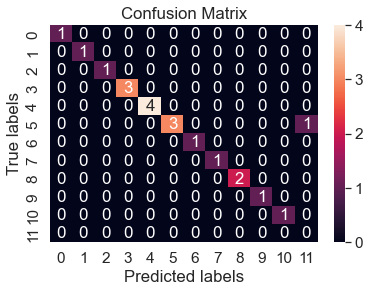

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

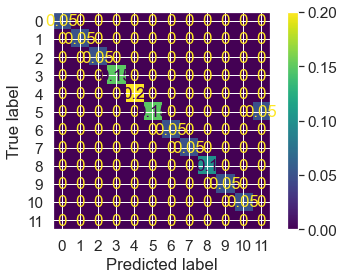

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix([t for w, t in ground_true_test_sentences[0]], 
                      [t for w, t in target_tagged_test_sentences[0]], 
                      normalize='all')
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

## Trigger training and evaluate on test set

### Case 1: $\alpha = 0.0$

In [ ]:
alpha = 0.

In [ ]:
# Set path for datadir
datadir = os.path.join("data", "penn-treebank3-wsj", "wsj")
train, dev, test = load_treebank_splits(datadir)
# Train the HMM model with add-smoothing and generate transition dictionary based on bigram as well as emission probability dictionary
c_bigram_tag_dict, c_single_tag_dict, emission_dict, word_cnt_dict, tags = train_model(train)
bigram_transition_dict = calculate_transition_probability(
    c_bigram_tag_dict, c_single_tag_dict, alpha
)
emission_prob_dict = calculate_emission_probability(
    emission_dict, c_single_tag_dict, len(word_cnt_dict), alpha
)

In [ ]:
ground_true_sentences, target_tagged_sentences = predict_hmm(
    dev, tags, bigram_transition_dict, emission_prob_dict
)
m = evaluate(ground_true_sentences, target_tagged_sentences)
print(m)

### Case 2: $\alpha = 1.0$

In [ ]:
alpha = 1.

In [ ]:
# Set path for datadir
datadir = os.path.join("data", "penn-treebank3-wsj", "wsj")
train, dev, test = load_treebank_splits(datadir)
# Train the HMM model with add-smoothing and generate transition dictionary based on bigram as well as emission probability dictionary
c_bigram_tag_dict, c_single_tag_dict, emission_dict, word_cnt_dict, tags = train_model(train)
bigram_transition_dict = calculate_transition_probability(
    c_bigram_tag_dict, c_single_tag_dict, alpha
)
emission_prob_dict = calculate_emission_probability(
    emission_dict, c_single_tag_dict, len(word_cnt_dict), alpha
)

Loading treebank data...
Train set size:  51681
Dev set size:  7863
Test set size:  9046
Finish training of HMM |c_bigram_tag_dict|=1517, |c_single_tag_dict|=79, |emission_dict|=51994, |word_cnt_dict|=44547, |tags|=79 with START, STOP
Generate bigram_transition_prob_dict for (t_i-1, t_i), pr(t_i-1|t_i) = 1517
Generate emission_prob_dict for (w_i, t_i), pr(w_i|t_i) = 51994


In [ ]:
ground_true_sentences, target_tagged_sentences = predict_hmm(
    dev, tags, bigram_transition_dict, emission_prob_dict
)
test_m = evaluate(ground_true_sentences, target_tagged_sentences)
print(test_m)

Trigger predict HMM with |target_set| = 7863


7863it [19:23,  6.76it/s]
/Users/llv23/opt/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/llv23/opt/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           #       1.00      1.00      1.00        31
           $       1.00      1.00      1.00      1248
          ''       1.00      0.99      0.99      1168
           (       1.00      1.00      1.00       244
           )       1.00      1.00      1.00       244
           ,       1.00      1.00      1.00      7931
           .       1.00      1.00      1.00      6125
           :       1.00      0.99      1.00       775
          CC       0.99      0.99      0.99      3777
          CD       0.99      0.95      0.97      5766
          DT       0.92      0.99      0.95     12639
          EX       0.96      0.36      0.52       133
          FW       0.11      0.04      0.06        25
          IN       0.92      0.99      0.95     15497
       IN|RB       0.00      0.00      0.00         1
          JJ       0.88      0.85      0.86      9014
         JJR       0.74      0.86      0.80       506
         JJS       0.85    

/Users/llv23/opt/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Baseline with word-max tag counter

In [ ]:
def baseline_model(train):
    """generate dictionary with word as key, a list of dictionary with tag as key and counter as value

    Args:
        train (raw data): raw input of training data
    """
    w_counter = {}
    train_sentences = [get_token_tag_tuples(sent) for sent in train]
    for s in train_sentences:
        sentence = refine_sentence(s)
        for w, t in sentence:
            if w in w_counter:
                if t in w_counter[w]:
                    w_counter[w][t] += 1
                else:
                    w_counter[w][t] = 1
            else:
                w_counter[w] = {t:1}
    # convert to the w to tag implementation
    w_tag_dict = {}
    for w, tag_counter in w_counter.items():
        w_tag_dict[w] = max(tag_counter, key=tag_counter.get)
    return w_tag_dict

In [ ]:
def predict_one_sentence_bybaseline(sentence, w_tag_dict):
    target_tagged_sentence = []
    for w, _ in sentence:
        target_tagged_sentence.append((w, w_tag_dict[w] if w in w_tag_dict else 'UNK'))
    return target_tagged_sentence

def predict_baseline(target_set, w_tag_dict):
    print(f"Trigger predict HMM with baseline |w_tag_dict| = {len(w_tag_dict)}")
    ground_true_sentences = [refine_sentence(get_token_tag_tuples(sent)) for sent in target_set]
    target_tagged_sentences = [None for _ in range(len(ground_true_sentences))]
    for i, target_sentence in enumerate(ground_true_sentences):
        target_tagged_sentences[i] = predict_one_sentence_bybaseline(
            target_sentence, w_tag_dict
        )
    return ground_true_sentences, target_tagged_sentences

In [ ]:
w_tag_dict = baseline_model(train)

In [ ]:
ground_true_sentences, target_tagged_sentences = predict_baseline(test, w_tag_dict)
m = evaluate(ground_true_sentences, target_tagged_sentences)
print(m)